In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from platform import python_version
print(pd.__version__)
print(np.__version__)
print(python_version())
print('Last Run ' + datetime.utcnow().strftime('%y%m%d_%H%M%SZ') + ' UTC.')

1.1.3
1.19.2
3.8.5
Last Run 210321_213712Z UTC.


In [2]:
%%capture
import os, timeit, json, io
from collections import Counter
import pandas as pd
import numpy as np
import math as mt
import scipy as sci
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sympy as sym
import functools as fct
import itertools as it
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from sympy import *
from sympy.utilities.lambdify import lambdify, implemented_function
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import integrate
import scipy.optimize
from scipy.constants import golden
# mpl.rcParams['font.sans-serif'] = "Nunito"
# mpl.rcParams['font.family'] = 'Nunito'


In [3]:
n = 4
a = IndexedBase('a')
𝜈, 𝘺, 𝛮, 𝗔, 𝝜= symbols('𝜈, 𝘺, 𝛮, 𝗔, 𝝜')
𝜈 = symbols('𝜈', cls = Idx)
𝛮 = n
𝗔 = np.transpose(np.vstack([np.asarray([a[2*𝜈] for 𝜈 in range(int(ceiling(𝛮)) )]),
                            np.asarray([a[2*𝜈+1] for 𝜈 in range(int(ceiling(𝛮)) )])] ))



In [4]:
#
# We perform linear solution of the quantile-distribution coefficients in accordance
# with [Keelin2016] as described above. Our arguments are;
# ⧐ series_len is the desired number of coefficients; and
# ⧐ resid_samps is the sample to which the metalog distribution is fit. 
# We return a numeric matrix 𝗮 containing the coefficients. 
def metalog_quantile_coeffs(series_len, resid_samps):
    #
    # Set values for series-length and sample-size variables.  We cannot have a
    # series lenght that exceeds the sample size.
    series_len = min(len(resid_samps), series_len) # Number of coefficients
    samp_size = len(resid_samps) # Number of observations
    #
    # Declare symbolic variables.
    𝜉, 𝜂, 𝜁, 𝓎 = symbols('𝜉, 𝜂, 𝜁, 𝓎')
    𝜈 = symbols('𝜈', cls = Idx)
    a = IndexedBase('a')
    #
    # Construct a row symbolic row vector of terms for a simgle sample.
    # This row vector contains elements from which we construct the data
    # matrix to which we fit the distribution seris. These terms correspond to
    # the convention of (4) in [Keelin2016].
    𝓎 = Matrix([𝜉*𝜁
                 for (𝜉, 𝜁) in list(it.product([(𝜂-Rational(1,2))**𝜈 for 𝜈 in range(int(ceiling(series_len/2)))],
                                                      [1, ln(𝜂/(1-𝜂))]))])
    𝓎.row_swap(2,3)
    if 𝓎.shape[0] > samp_size:
        𝓎.row_del(samp_size)
    #
    # Define an `implemented_function` in order to build the rows of the
    # model matrix. This substitutes the empirical cumulative distribution 
    # (ECDF) values for the row-vector elements. The pattern is described in
    # SymPy documentation https://t.ly/15sg. 
    f = implemented_function('f', lambda 𝜉 : np.array(𝓎.subs(𝜂, 𝜉))
                                               .astype(np.float64))
    𝜆_𝓎 = lambdify(𝜉, f(𝜉))
    #
    # Construct an ECDF for our residual sample set. Sort the sample set
    # while constructing.
    resid_samps = np.sort(resid_samps)
    𝒫 = ECDF(resid_samps)(resid_samps)
    #
    # Use the statsmodels.regression.linear_model.OLS function to solve for
    # the model coefficients https://t.ly/QgMv to estimate the coefficients.
    # We drop the final sample, for which the ECDF value is unity. This provides
    # problems for the logarithmic terms in the metalog terms.
    metalog_ols = sm.OLS(endog = resid_samps[:-1],
                         exog = np.matrix.transpose(np.hstack([𝜆_𝓎(𝑦) for 𝑦 in 𝒫[:-1]])),
                         hasconst = True).fit()
    #
    # Our coefficient vector is the regression coefficients, resulting from the `params` method.
    return (metalog_ols.params,
            metalog_ols.rsquared)
#
# Construct a symbolic representation of the metalog series. This
# is (4) from [Keelin2016]. It differs from the printed form in that
# coefficients are zero-indexed as opposed to unity-indexed.
def metalog_quantile_series(n):
    a = IndexedBase('a')
    𝜈, y, 𝛮, 𝗔, 𝝜= symbols('𝜈, y, 𝛮, 𝗔, 𝝜')
    𝜈 = symbols('𝜈', cls = Idx)
    𝛮 = n
    𝗔 = np.transpose(np.vstack([np.asarray([a[2*𝜈] for 𝜈 in range(int(ceiling(𝛮)) )]),
                                np.asarray([a[2*𝜈+1] for 𝜈 in range(int(ceiling(𝛮)) )])] ))
    𝗔 = np.vstack([𝗔[0,:],
                    np.flip(m = 𝗔[1,:],
                            axis = 0),
                    𝗔[2:,:]])

    𝝜 = ((Matrix([Pow(y-Rational(1,2), 𝜈) 
                   for 𝜈 in range(int(ceiling(𝛮)))]).T)*𝗔*Matrix([[1],
                                                                   [ln(y/(1-y))]]))\
            .subs([(a[𝜈],0) for 𝜈 in range(𝛮,2*𝛮+1)])
    return 𝝜[0,0]
#



# Construct a function to numerically calculate values from
# a symbolic function based on a metalog series. 
# For flexibility, these functions are represented
# as symbolic objects. This is suboptimum for numeric-calculation
# purposes. Here, we create a function that numerically calculates 
# quantile-function values in a more-efficient fashion.
#
# Our function inputs are:
# ⧐ `metalog_based_function` is a symbolic representation of a
#    function based on a metalog quantile series; and
# ⧐ `megalog_coeffs` is a corresponding set of coeffients.
#
# This function performs substitution operations to replace the 
# symbolic coefficients in `metalog_based_series` with numeric
# values from `metalog_coeffs`. It then uses the SymPi `lambdify`
# feature to transform the symbolic object into a numeric function
# according to the logic patter in https://t.ly/FqPc.
#
def construct_metalog_based_fct(metalog_based_function,
                                metalog_coeffs):
    # Declare symbolic variables.
    a = IndexedBase('a') # An indexed variable for coefficients.
    𝜉, 𝜂, 𝜁, y = symbols('𝜉, 𝜂, 𝜁, y') # Domain and range variables.
    #
    # Create a dictionary mapping index-based symbols to their
    # numerical values in `metalog_coeffs`.
    coeff_map = dict(zip([a[𝜄] for 𝜄 in range(series_len)],
                         metalog_coeffs))
    #
    # Define the `implemented_function` object and then lambdify.
    # Apply the pattern in https://t.ly/BUbo. Our implemented_function
    # substitutes the index-based coefficient symbols for their numeric values,
    # and the main-function domain variable for another.
    metalog_fct = implemented_function('metalog_fct', lambda 𝜂: metalog_based_function.subs(y, 𝜂)\
                                                                                      .subs(coeff_map))
    metalog_fct_𝜆 = lambdify(y, metalog_fct(y) )
    #
    # Return our lambdified object.
    return metalog_fct_𝜆
#


In [5]:
# Read in the model-residual data. This is contained in an json file.
# Upon reading it in, we immediately transform it to a dictionary using
# the `pandas.DataFrame.from_dict(orient = 'index')` method. Our dictionary 
# indices got transformed to strings when exported as json. We need immediately 
# to cast them as integers.
model_residuals = pd.DataFrame.from_dict(data = json.load(open(os.path.join('../data',
                                                                            'model_residuals.json'))),
                                         orient = 'index')\
                              .rename_axis(index = 'hashkey')
model_residuals.rename(index = dict(zip(model_residuals.index.tolist(),
                                        map(int, model_residuals.index.tolist()))),
                       inplace = True)

In [6]:
# Our data contain k-neighbor clusters of estimates and residuals.
# These result from looking for the best k-neighbors regressor fit
# of the estimates to the residuals. This produces an approximation
# of LOWESS. Draw out a sample neighborhood of (estimate, residual)
# tuples. We subsequently fit the residuals' scatter in this neighborhood
# to a metalog distribution.
sample_neighborhood = model_residuals.loc[model_residuals.loc[np.random.choice(a = model_residuals.index),
                                                              'resid_cluster'],
                                          ['estimate', 'residual', 'lowess']].sort_values(by = 'estimate')

In [7]:
series_len = 4
resid_samps = np.sort(sample_neighborhood['residual'])

metalog_based_function = metalog_quantile_series(series_len)
metalog_coeffs = metalog_quantile_coeffs(series_len, 
                                         resid_samps)[0]
M_𝓎 = construct_metalog_based_fct(metalog_based_function,
                                  metalog_coeffs)
resid_samps_ecdf = ECDF(resid_samps)(resid_samps)

In [8]:
quantile_cuts = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
pd.Series(dict(zip(quantile_cuts, 
         map(M_𝓎, quantile_cuts)))).astype(float)

0.05   -21532.419680
0.10   -13067.344759
0.25    -3852.992936
0.50     1194.867001
0.75     6365.693832
0.90    15850.572819
0.95    24515.377817
dtype: float64

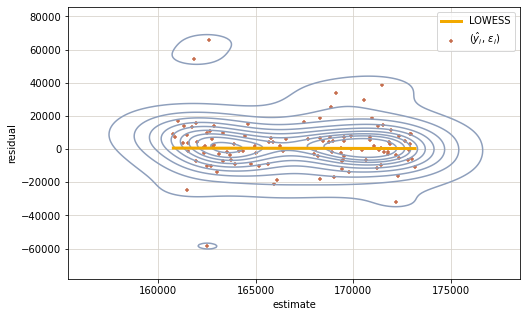

In [9]:
# Visualize the distribution of residuals in the neighborhood.
# 
est_resid_fig, est_resid_ax = plt.subplots(nrows = 1,
                                           ncols = 1,
                                           figsize = (5 * golden, 5))
est_resid_ax.scatter(sample_neighborhood['estimate'],
                     sample_neighborhood['residual'],
                     marker = '+',
                     s = 10,
                     color = '#c66e4e',
                     label = '$(\hat{y}_i,\,\epsilon_i)$')
sns.kdeplot(data = sample_neighborhood,
            x = 'estimate',
            y = 'residual',
            ax = est_resid_ax,
            color = '#8e9fbc')
est_resid_ax.plot(sample_neighborhood['estimate'],
                  sample_neighborhood['lowess'],
                  color = '#f2a900',
                  linewidth = 3,
                  label = 'LOWESS')
est_resid_ax.legend();
est_resid_ax.grid(color = '#d7d2cb')

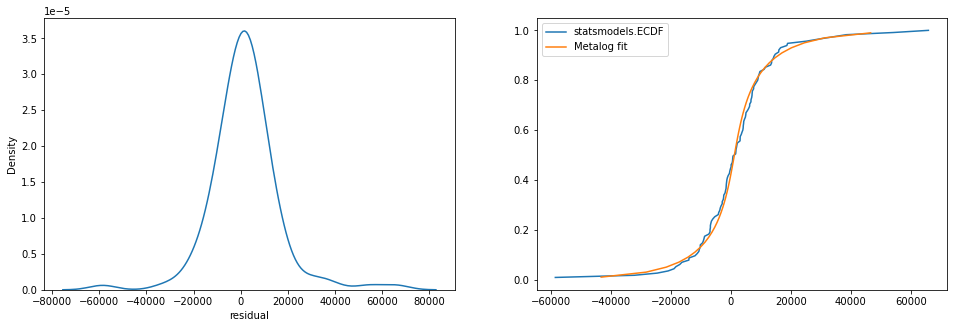

In [10]:
resid_fig, (resid_kde, resid_ecdf_ax) = plt.subplots(nrows = 1,
                                                   ncols = 2,
                                                   figsize = (10 * golden, 5))
sns.kdeplot(data = sample_neighborhood,
            x = 'residual',
            ax = resid_kde)
resid_ecdf_ax.plot(resid_samps, 
                   resid_samps_ecdf,
                   label = 'statsmodels.ECDF')
resid_ecdf_ax.plot(list(map(M_𝓎,
                         np.linspace(start = 0.01,
                                     stop = 0.99,
                                     num = 50))),
                np.linspace(start = 0.01,
                             stop = 0.99,
                             num = 50),
                label = 'Metalog fit')
resid_ecdf_ax.legend();

In [11]:
hashkey = np.random.choice(a = model_residuals.index)

In [12]:

model_residuals.loc[model_residuals.loc[hashkey,
                                       'resid_cluster'],
                   ['estimate', 'residual', 'lowess']]

,estimate,residual,lowess
hashkey,,,
3499675265606759270,403441.491543,21558.508457,10844.334550
2131069649194163858,408760.673325,93076.326675,11232.256417
-31759830283846821,399067.815071,-14067.815071,10525.485040
-354344504592484847,412102.274359,34158.725641,11475.986917
7038156713613545229,412236.885943,-2236.885943,11485.805359
...,...,...,...
1160745910380347583,316993.589320,33006.410680,4991.553884
-1196740800141569341,316482.459518,-3482.459518,4960.675522
7376176920508556600,316133.631687,8866.368313,4939.572822


In [13]:
resid_quantiles = dict()
failed_estiamte = list()
quantile_cuts = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
series_len = 5
metalog_based_function = metalog_quantile_series(series_len)
for hashkey in model_residuals.index:
    sample_neighborhood = model_residuals.loc[model_residuals.loc[hashkey,
                                                                   'resid_cluster'],
                                               ['estimate', 'residual', 'lowess']].sort_values(by = 'estimate')
    resid_samps = np.sort(sample_neighborhood['residual'])
    metalog_coeffs = metalog_quantile_coeffs(series_len, 
                                             resid_samps)[0]
    M_𝓎 = construct_metalog_based_fct(metalog_based_function,
                                      metalog_coeffs)
    try:
        resid_quantiles.update({hashkey : dict(zip(quantile_cuts,
                                                    map(M_𝓎, quantile_cuts)))})
    except:
        failed_estiamte.update(hashkey)    

In [17]:
residual_quantile_cuts = pd.merge(left = model_residuals[['estimate']],
                                 right = pd.DataFrame.from_dict(data = resid_quantiles,
                                                                orient = 'index').astype(float),
                                 left_index = True,
                                 right_index = True).set_index(keys = 'estimate',
                                                               drop = True)\
                                                    .sort_index(axis = 0)

In [18]:
residual_quantile_cuts

,0.05,0.10,0.25,0.50,0.75,0.90,0.95
estimate,,,,,,,
42883.022085,-35319.062396,-24494.121809,-10914.154688,-1865.042121,5671.656694,18782.717485,31368.408817
43912.459716,-33442.371827,-23640.829102,-10796.230085,-1792.552880,5252.299762,17035.260163,28446.947379
45796.806568,-33158.978879,-23449.275406,-10715.485557,-1780.179730,5206.470074,16878.593410,28181.910590
48887.244889,-34273.105396,-24168.649678,-11011.077655,-1849.170995,5384.162196,17531.819690,29273.677737
49604.008642,-33189.925135,-23470.494591,-10724.556070,-1781.447729,5211.474166,16895.410944,28210.442379
...,...,...,...,...,...,...,...
508789.763940,-254221.642955,-131936.368651,-25994.811237,7329.249673,64739.235196,176580.175179,268510.939274
511457.739217,-256639.589880,-133801.954979,-27003.435079,6633.115762,63736.066136,176234.460587,269427.871422
518920.841715,-253397.613450,-131809.793450,-26619.048072,6524.002970,64115.099847,175858.189898,267467.655921


In [25]:
quant_cut = np.random.choice(a = residual_quantile_cuts.columns)
cut_lowess = lowess(endog = residual_quantile_cuts[quant_cut],
                          exog = residual_quantile_cuts.index)


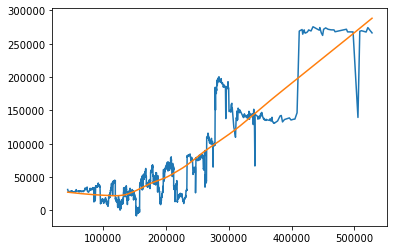

In [27]:
plt.plot(residual_quantile_cuts.index,
         residual_quantile_cuts[quant_cut])
plt.plot(quant_cut_lowess[:,0],
         quant_cut_lowess[:,1])

⛔️🛑🚫⛔️🛑🚫⛔️🛑🚫⛔️🛑🚫⛔️🛑🚫⛔️🛑🚫⛔️🛑🚫⛔️🛑🚫⛔️🛑🚫⛔️🛑🚫⛔️🛑🚫

In [29]:
#
# Set values for series-length and sample-size variables.  We cannot have a
# series lenght that exceeds the sample size.
series_len = min(len(resid_samps), series_len) # Number of coefficients
samp_size = len(resid_samps) # Number of observations
#
# Declare symbolic variables.
𝜉, 𝜂, 𝜁, 𝓎 = symbols('𝜉, 𝜂, 𝜁, 𝓎')
𝜈 = symbols('𝜈', cls = Idx)
#
# Construct a row symbolic row vector of terms for a simgle sample.
# This row vector contains elements from which we construct the data
# matrix to which we fit the distribution seris. These terms correspond to
# the convention of (4) in [Keelin2016].
𝓎 = Matrix([𝜉*𝜁
             for (𝜉, 𝜁) in list(it.product([(𝜂-Rational(1,2))**𝜈 for 𝜈 in range(int(ceiling(series_len/2)))],
                                                  [1, ln(𝜂/(1-𝜂))]))])
𝓎.row_swap(2,3)
if 𝓎.shape[0] > samp_size:
    𝓎.row_del(samp_size)
#
# Define an `implemented_function` in order to build the rows of the
# model matrix. This substitutes the empirical cumulative distribution 
# (ECDF) values for the row-vector elements. The pattern is described in
# SymPy documentation https://t.ly/15sg. 
f = implemented_function('f', lambda 𝜉 : np.array(𝓎.subs(𝜂, 𝜉))
                                           .astype(np.float64))
𝜆_𝓎 = lambdify(𝜉, f(𝜉))
#
# Construct an ECDF for our residual sample set. Sort the sample set
# while constructing.
resid_samps = np.sort(resid_samps)
𝒫 = ECDF(resid_samps)(resid_samps)
#
# Use the statsmodels.regression.linear_model.OLS function to solve for
# the model coefficients https://t.ly/QgMv to estimate the coefficients.
# We drop the final sample, for which the ECDF value is unity. This provides
# problems for the logarithmic terms in the metalog terms.
metalog_ols = sm.OLS(endog = resid_samps[:-1],
                     exog = np.matrix.transpose(np.hstack([𝜆_𝓎(𝑦) for 𝑦 in 𝒫[:-1]])),
                     hasconst = True).fit()

In [35]:
metalog_ols.rsquared

0.9915801951759787

In [10]:
np.linalg.lstsq(a = np.matrix.transpose(np.hstack([𝜆_𝓎(𝑦) for 𝑦 in 𝒫[:-1]])),
                            b = resid_samps[:-1],
                            rcond = -1)[0]

array([ -1056.24997834,   9098.55218418,  -5945.98450303, -17830.15551391,
        27504.7179416 ])

In [11]:
metalog_ols = sm.OLS(endog = resid_samps[:-1],
                     exog = np.matrix.transpose(np.hstack([𝜆_𝓎(𝑦) for 𝑦 in 𝒫[:-1]])),
                     hasconst = True).fit()
metalog_ols.params

array([ -1056.24997834,   9098.55218418,  -5945.98450303, -17830.15551391,
        27504.7179416 ])

In [12]:
metalog_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     4089.
Date:                Fri, 19 Mar 2021   Prob (F-statistic):          1.74e-119
Time:                        22:57:28   Log-Likelihood:                -952.37
No. Observations:                 116   AIC:                             1915.
Df Residuals:                     111   BIC:                             1929.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1056.2500    139.864     -7.552      0.000   -1333.400    -779.100
x1          9098.5522    203.811     44.642      0.000    8694.688    9502.417
x2         -5945.9845    567.275    -10.482      0.000   -7070.079   -4821.890
x3         -1.783e+04   1220.514    -14.609      0.000   -2.02e+04   -1.54e+04
x4           2.75e+04   4181.315      6.578      0.000    1.92e+04    3.58e+04
==============================================================================
Omnibus:                       25.500   Durbin-Watson:                   1.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.069
Skew:                          -0.314   Prob(JB):                     1.59e-38
Kurtosis:                       8.968   Cond. No.                         86.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# a = IndexedBase('a')
# 𝜈, 𝘺, 𝛮, 𝗔, 𝘆 = symbols('𝜈, 𝘺, 𝛮, 𝗔, 𝘆')
# 𝜈 = symbols('𝜈', cls = Idx)
# 𝛮 = len(𝒫[0])
def metalog_quantile_series(n):
    a = IndexedBase('a')
    𝜈, 𝘺, 𝛮, 𝗔, 𝝜= symbols('𝜈, 𝘺, 𝛮, 𝗔, 𝝜')
    𝜈 = symbols('𝜈', cls = Idx)
    𝛮 = n
    𝗔 = np.transpose(np.vstack([np.asarray([a[2*𝜈] for 𝜈 in range(int(ceiling(𝛮)) )]),
                                np.asarray([a[2*𝜈+1] for 𝜈 in range(int(ceiling(𝛮)) )])] ))
    𝗔 = np.vstack([𝗔[0,:],
                    np.flip(m = 𝗔[1,:],
                            axis = 0),
                    𝗔[2:,:]])

    𝝜 = ((Matrix([Pow(𝘺-Rational(1,2), 𝜈) 
                   for 𝜈 in range(int(ceiling(𝛮)))]).T)*𝗔*Matrix([[1],
                                                                   [ln(𝘺/(1-𝘺))]]))\
            .subs([(a[𝜈],0) for 𝜈 in range(𝛮,2*𝛮+1)])
    return 𝝜[0,0]
#
#
# y = IndexedBase('y')
# 𝗫, 𝗬, 𝜇, 𝜈, 𝘔, 𝘕, 𝜉, 𝜁, 𝜂 = symbols('𝗫, 𝗬, 𝜇, 𝜈, 𝘔, 𝘕, 𝜉, 𝜁, 𝜂')
# 𝜇 = symbols('𝜇', cls = Idx)
# 𝜈 = symbols('𝜈', cls = Idx)
# 𝘔 = len(𝒫[0]) # Number of coefficients
# 𝘕 = len(𝒫[0]) # Number of observations
#
# We perform linear solution of the quantile-distribution coefficients in accordance
# with [Keelin2016] as described above. Our arguments are;
# ⧐ 𝘔 is the desired number of coefficients; and
# ⧐ 𝒫 is the empirical cumulative distribution. 
# We return a symbolic matrix 𝗮 containing the coefficients. 
def metalog_quantile_coeffs(𝘔, 𝒫):
    𝘔 = min(len(𝒫[0]), 𝘔) # Number of coefficients
    𝘕 = len(𝒫[0]) # Number of observations
    𝜉, 𝜂, 𝜁, 𝓎 = symbols('𝜉, 𝜂, 𝜁, 𝓎')
    𝜈 = symbols('𝜈', cls = Idx)
    𝓎 = Matrix([𝜉*𝜁
                 for (𝜉, 𝜁) in list(it.product([(𝜂-Rational(1,2))**𝜈 for 𝜈 in range(int(ceiling(𝘔/2)))],
                                                      [1, ln(𝜂/(1-𝜂))]))])
    𝓎.row_swap(2,3)
    if 𝓎.shape[0] > 𝘔:
        𝓎.row_del(𝘔)

    f = implemented_function('f', lambda 𝜉 : np.array(𝓎.subs(𝜂, 𝜉))\
                                               .astype(np.float64))
    𝜆_𝓎 = lambdify(𝜉, f(𝜉))
    return np.linalg.lstsq(a = np.matrix.transpose(np.hstack([𝜆_𝓎(𝑦) for 𝑦 in 𝒫[0]])),
                            b = 𝒫[1],
                            rcond = -1)[0]
#
# We perform linear solution of the quantile-distribution coefficients in accordance
# with [Keelin2016] as described above. Our arguments are;
# ⧐ 𝘔 is the desired number of coefficients; and
# ⧐ 𝒫 is the empirical cumulative distribution. 
# We return a symbolic matrix 𝗮 containing the coefficients. 
def metalog_quantile_coeffs_lb(𝘔, 𝒫, 𝒷ℓ):
    𝘔 = min(len(𝒫[0]), 𝘔) # Number of coefficients
    𝘕 = len(𝒫[0]) # Number of observations
    y = IndexedBase('y')
    𝗬, 𝜇, 𝜈, 𝜉, 𝜁, 𝜂 = symbols('𝗬, 𝜇, 𝜈, 𝜉, 𝜁, 𝜂')
    𝜇 = symbols('𝜇', cls = Idx)
    𝜈 = symbols('𝜈', cls = Idx)
    𝗬 = Matrix([[(𝜉*𝜁).subs(𝜂, y[𝜇])
                   for (𝜉, 𝜁) in list(it.product([(𝜂-Rational(1,2))**𝜈 for 𝜈 in range(int(ceiling(𝘔/2)))],
                                                [1, ln(𝜂/(1-𝜂))]))]
                for 𝜇 in range(𝘕)])
    𝗬.col_swap(2,3)
    if 𝗬.shape[1] > 𝘔:
         𝗬.col_del(𝘔)
    return np.linalg.lstsq(a = np.array(𝗬.subs(list(zip([y[𝜇] for 𝜇 in range(𝘕)],
                                                            𝒫[0])))).astype(dtype = 'float64'),
                            b = np.log(𝒫[1]-𝒷ℓ),
                            rcond = -1)[0]
#
# Here we construct two functions, r=M_𝗮(𝘺) and dr/dy = m_𝗮(𝘺). These compile the quantile (aka
# percentile-point) function and its derivative for computational purposes.  We get the probability-
# density function pᵣ(r) ∼ (dr/d𝘺)⁻¹. Each function takes the same two arguments
# ⧐ 𝛂 is a coefficient vector resulting from a metalog_quantile_fit; and
# ⧐ 𝜂 is an array of quantile points to which the function is mapped.
# In each case, the following logical steps occur.
# ⓐ Invoke metalog_quantile_series to get a metalog series whose coefficients
#    correspond to the length of 𝛂.  
# ⓑ In the case of m_𝗮(𝘺), symbolically otbain the first derivative with respect to 𝘺.
# ⓒ Substitute the values of 𝛂 for the symbolically-represented coefficients above.
# ⓓ Apply lambdify to compile the symbolic function to the result of ⓒ for purposes
#    of calculation.
# ⓔ Employ python's map function to calculate the function value for each point in 𝜂.
# Each function returns a numpy array.
def m_𝗮(𝛂, 𝜂):
    𝘺, 𝛯 = symbols('𝘺, 𝛯')
    a = IndexedBase('a')
    𝛯 = metalog_quantile_series(len(𝛂)).subs({a[key]: val
                                        for (key, val) in dict(enumerate(𝛂)).items()})
    return np.array(list(map(lambdify(𝘺, 1/diff(𝛯, 𝘺)), 𝜂)))
def M_𝗮(𝛂, 𝜂):
    𝘺, 𝛯 = symbols('𝘺, 𝛯')
    a = IndexedBase('a')
    𝛯 = metalog_quantile_series(len(𝛂)).subs({a[key]: val
                                        for (key, val) in dict(enumerate(𝛂)).items()})
    return np.array(list(map(lambdify(𝘺, 𝛯), 𝜂)))
def m_𝗮_lb(𝛂, 𝒷ℓ, 𝜂):
    𝘺, 𝛯 = symbols('𝘺, 𝛯')
    a = IndexedBase('a')
    𝛯 = exp(metalog_quantile_series(len(𝛂)).subs({a[key]: val
                                                    for (key, val) in dict(enumerate(𝛂)).items()})) + 𝒷ℓ
    return np.array(list(map(lambdify(𝘺, 1/diff(𝛯, 𝘺)), 𝜂)))
def M_𝗮_lb(𝛂, 𝒷ℓ, 𝜂):
    𝘺, 𝛯 = symbols('𝘺, 𝛯')
    a = IndexedBase('a')
    𝛯 = exp(metalog_quantile_series(len(𝛂)).subs({a[key]: val
                                                    for (key, val) in dict(enumerate(𝛂)).items()})) + 𝒷ℓ
    return np.array(list(map(lambdify(𝘺, 𝛯), 𝜂)))

#
# We construct here a function that constructs the gradient of the 𝕃²-Norm
# of a vector. We use this to impose a structural regularization in constrained-
# optimization problems. We take as our input a dictionary whose keys are 
# vector-element labels and whose values are the vector-element values. We 
# symbolically construct the norm itself and create a gradient vector. We then
# substitute the values in and return the result. Specifically, we return a dictionary
# for which the items are:
# ⧐ '∇_𝗮' is the gradient vector itself; and
# ⧐ 'Z_𝗮' is its nullspace.
def vec_norm_grad(𝗮):
    # Define our vector.
    vec = Matrix([𝜃 for 𝜃 in 𝗮.keys()])
    #
    # Construct the vector norm.
    norm = sqrt(vec.dot(vec.transpose()))
    #
    # Substitute in the values and return the result.
    grad_𝗮 = np.array(Matrix([diff(norm, 𝜃) for 𝜃 in 𝗮.keys()]).subs(𝗮)).astype('float64')
    null_𝗮 = np.subtract(np.identity(len(grad_𝗮)),
                        np.dot(a = grad_𝗮,
                               b = np.transpose(grad_𝗮)))
    u, s, vh = np.linalg.svd(null_𝗮)
    return {'∇_𝗮' : grad_𝗮,
            'Z_𝗮' : u[:,list(range(np.linalg.matrix_rank(null_𝗮)))]}


#
# Ⓒ Define a function 𝜙(𝗮) that calculates (10).  Our arguments are 
#    ⪧ A coefficient vector 𝛂; and
#    ⪧ 𝜂 a set of integrand samples.
#    Our function invokes m_𝗮_lb in order to get a set of functional values 
#    on 𝜂. It then performs a trapezoidal approximation of the integration.
def 𝜙_𝗮(𝛂, 𝜂):
    𝓘 = np.log(m_𝗮_lb(𝛂 = 𝛂, 
                      𝒷ℓ = 0,
                      𝜂 = 𝜂))
    return np.trapz(y = 𝓘,
                    x = 𝜂)



<font color = '#1a2f5f'>

# Fitting Metalog Distributions Using Kullback-Liebler Distance

</font>

We demonstrate here the fitting of one metalog to another by minimization of the Kullback-Liebler "distance"  [[Cover2006, (2.26)]](https://www.amazon.com/Elements-Information-Theory-Thomas-Cover-ebook/dp/B00HLG9ISQ) between the two distributions.  Our distributions are specified in terms of Metalog functions [[Keelin2016]](https://pubsonline.informs.org/doi/abs/10.1287/deca.2016.0338) $$   \begin{align} M_\mathscr{X}(y;\,\boldsymbol{\mathrm{a}}) &= \displaystyle \sum_{\nu = 1}^{\frac{n}{2}} \Bigg( a_{2\nu -1} \, \Big( y-\frac{1}{2}\Big)^{(2\nu - 1)}  \\ &\qquad\quad+ a_{2 \nu}\,\Big(y-\frac{1}{2}\Big)^{(2 \nu -1)}\, \ln\Big(\frac{y}{1-y} \Big) \Bigg) \\ &\qquad\qquad\qquad\qquad\qquad\forall \; y \in\big(0,\,1\big) \end{align} \text{,}  \qquad \text{(1a)}   $$ where $$\begin{split} \mathscr{x}=M_\mathscr{X}(\mathscr{y})\iff y=\mathcal{Pr}\big(\mathscr{X}\leq\mathscr{x}\big) = P_\mathscr{X}(\mathscr{x}) \\  \forall \quad \mathscr{x} \in \mathbb{R} \; \land \; \mathscr{y} \in [0,1]\text{.} \end{split} \qquad \text{(1b)} $$ In (1), $M_\mathscr{X}(y;\,\boldsymbol{\mathrm{a}})$ is often referred to as a  *percentile-point function* (PPF) (e.g., [[scipy.stats.laplace]](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.laplace.html#scipy.stats.laplace) ). Respresented by a vector $\boldsymbol{\mathrm{a}}$ of coefficients, $M_\mathscr{X}(y;\,\boldsymbol{\mathrm{a}})$ results from a fit to an *emprical cumulative-distrubution function* (ECDF). We alternatively think of (1b) as a functional mapping $$M_\mathscr{X} : [0,1] \mapsto \mathbb{R} \text{.} \qquad \qquad \text{(1c)}  $$

We have two distributions, $p_\mathscr{X}(x)$ and $\hat{p}_\mathscr{X}(x;\,\boldsymbol{\mathrm{a}})$, the latter of which is derived from a matalog-fit (1) PPF. We seek the coefficient vector $\boldsymbol{\mathrm{a}}$ producing $\hat{p}_\mathscr{X}(x;\,\boldsymbol{\mathrm{a}})$ that most-closely coincides with $p_\mathscr{X}(x)$. For convenience we adopt the notation $$\phi(\boldsymbol{\mathrm{a}}) = \int_{x \in \mathbb{R}}p_\mathscr{X}(x)\, \ln\bigg(\tfrac{p_\mathscr{X}(x)}{\hat{p}_{\mathscr{X}}(x;\,\boldsymbol{\mathrm{a}})} \bigg)\: dx \qquad \text{(2)} $$ to denote our KL distance. We seek an optimum coefficient vector $\boldsymbol{\mathrm{a}}^*$ that optimizes $$\boldsymbol{\mathrm{a}}^* = \arg \max_{\boldsymbol{\mathrm{a}}} \phi(\boldsymbol{\mathrm{a}}) \; \ni \; \| \boldsymbol{\mathrm{a}} \| \le \| \boldsymbol{\mathrm{a}}_0 \| \text{.}\qquad\text{(3)}$$ The constraint represents a structural regularization. It serves the same purpose as the constraints in Lasso- and Ridge-regression methods [[Hastie2006, §3.4]](https://www.springer.com/gp/book/9780387848570). Its presence prevents certain trivial or degenerate conditions. 

<font color = '#0051ba'>
    
### Deriving the KL "distance" from metalog PPF functions. 
</font>

Now, our probability-space structure is specified in terms of PPFs (1). Our objective function however appears in the form of the more-familiar probability-density functions (2).  We must effect changes to our variables of integration to reconcile this disparity.

<font color = '#003459'>
    
#### Transforming $\phi(\boldsymbol{\mathrm{a}})$ into an integral in terms of $y$. 
</font>

The relationships in (1b) provide us oiur bridge. From basic differential calculus we have$$\begin{gather} p_\mathscr{X}(x)=\tfrac{dy}{dx}=\tfrac{d\,P_\mathscr{X}(x)}{dx}\text{,} \qquad \text{(3a)} \\ \tfrac{dx}{dy}=\tfrac{d\,M_\mathscr{X}(y)}{dy} = m_\mathscr{X}(y) \text{,} \qquad \text{(3b)} \\ \text{and}\\ \tfrac{dy}{dx}=\tfrac{1}{dx/dy}\text{.} \qquad \text{(3c)}\end{gather} $$ We use these to change (2) from an integral in terms of $p_\mathscr{x}(x)$ and $x$ to one interms of the corresponding $m_\mathscr{X}(y)$ and $y$.  First, (3a) gives us $$m_\mathscr{X}(y)\,dy = dx \text{.} \qquad \qquad \text{(4a)}$$ Also, applying concepts from basic differential calculus, (3b) and (3c) give us $$p_\mathscr{X}(x) = \tfrac{1}{m_\mathscr{X}(y)}\text{.} \qquad \qquad \text{(b)} $$  By substitution, our objective function (2) now becomes $$\phi(\boldsymbol{\mathrm{a}}) = \int_0^1 \ln \bigg(\tfrac{\hat{m}_\mathscr{X}(y;\,\boldsymbol{\mathrm{a}})}{m_\mathscr{X}(y)} \bigg) dy \text{.} \qquad \qquad \text{(5)} $$  The relative simplicity of (5) with respect to (2) is surprising, but convenient.

<font color = '#003459'>
    
#### A simple illustration:  The KL distance between a Normal and Rayleigh distribution. 
</font>

Consider two classical distributions from the exponential family.  The KL "distance" of a Rayleigh distribution with respect to a Normal distribution. If in terms of (2) we selct $$p_\mathscr{X}(x) = \tfrac{1}{\sqrt{2 \pi}}\mathrm{e}^{-\tfrac{x^2}{2}} $$ and $$\hat{p}_\mathscr{X}(x;\,\boldsymbol{\mathrm{a}}) = x\,\mathrm{e}^{-\tfrac{x^2}{2}}\mathbb{u}(x)\text{,} $$ where the unit-step function $$\mathbb{u}(x) = \begin{cases}1 \quad &\forall \; x \ge 0 \\ 0 \quad &\forall \; x \lt 0 \end{cases} \text{.}$$ Substituting these density functions into (2) produces for this stylized example a closed-form result, $$\begin{aligned}\phi(\boldsymbol{\mathrm{a}}) &= \int_{-\infty}^\infty \tfrac{1}{\sqrt{2 \pi}}\mathrm{e}^{-\tfrac{x^2}{2}} \ln \bigg(\tfrac{1}{\sqrt{2 \pi}}\mathrm{e}^{-\tfrac{x^2}{2}} \bigg)\: dx \\ &\qquad -\int_0^\infty  \tfrac{1}{\sqrt{2 \pi}}\mathrm{e}^{-\tfrac{x^2}{2}} \ln \bigg(x\,\mathrm{e}^{-\tfrac{x^2}{2}}  \bigg)\: dx \\ &= \tfrac{1}{4} \ln \big(\tfrac{ \mathrm{e}^{\gamma -1}}{2 \pi^2}  \big) \\ &\approx -0.85135 \end{aligned}{\text{,}} \qquad \text (6)$$ where $\gamma \approx 0.577216$ is Euler's constant.  Wolfram Mathematica produces the result above. 

We now corroborate this result using Metalog fits to ECDFs for the distributions identified above. We calculate $\phi(\boldsymbol{\mathrm{a}})$ using (5). Following the approach in [[Keelin2016, §§3.1, 4.1]](https://pubsonline.informs.org/doi/abs/10.1287/deca.2016.0338), we get  $$\begin{multline} M_\mathscr{X}(𝘺) =  0.00026 𝘺 \log{\left(- \frac{𝘺}{𝘺 - 1} \right)} + 0.813849 𝘺 + 0.432775 \log{\left(- \frac{𝘺}{𝘺 - 1} \right)} - 0.4070265 \end{multline} \qquad \text{(6a)}$$ as the PPF for the normal distribution and $$ \hat{M}_\mathscr{X}(y;\,\boldsymbol{\mathrm{a}}) = 1.07491060501907 \left(- \frac{𝘺}{𝘺 - 1}\right)^{0.4257305} e^{𝘺 \left(0.207063 - 0.224511 \log{\left(- \frac{𝘺}{𝘺 - 1} \right)}\right)}\qquad \text{(6b)}$$ for the Rayleigh.

We take this one at a time. Equation (2) can be decomposed as $$\begin{aligned}\phi(\boldsymbol{\mathrm{a}}) &= \int_{x \in \mathbb{R}}p_\mathscr{X}(x)\, \ln\big(p_\mathscr{X}(x) \big)\: dx \\ &\qquad - \int_{x \in \mathbb{R}}p_\mathscr{X}(x)\, \ln\big(\hat{p}_{\mathscr{X}}(x;\,\boldsymbol{\mathrm{a}}) \big)\: dx \\ &= H(X) -  \mathcal{E}\Big\{\ln \big(\hat{p}_\mathscr{X}(x) \big) \Big\} \end{aligned}\text{.}\qquad \qquad \text{(8)}$$  Now, the first term in (8) is simply the negative entropy  [[Cover2006, (2.1)]](https://www.amazon.com/Elements-Information-Theory-Thomas-Cover-ebook/dp/B00HLG9ISQ) of the unit-variance Gaussian, $$H(X) = - \int_{x \in \mathscr{X}} p_\mathscr{x}(x)\, \ln \big( p_\mathscr{x}(x) \big) \: dx \text{.}\qquad \qquad \text{(9a)}$$ In terms of $m_\mathscr{X}(y)$ equivalently obtain $$H(X) = \int_{y \in [0,1]}  \ln \big( m_\mathscr{x}(y) \big) \: dy \text{.}\qquad \qquad \text{(9b)} $$  

Numerical integration over by the trapezoidal method [[Andre2003, §12.1]](https://amzn.to/32hobOB) with 10,000 samples produces $H(X) \approx  1.4274$. The corresponding exact calculation in (6) appears as $H(x) = \ln \big( \sqrt{2\,\pi\,\mathrm{e}} \big) \approx 1.4189$. The difference can be explained by the use of only four coefficients to approximate $M_\mathscr{X}(y)$ in (6a). If we increase the number of coefficients to ten, our approximation improves to $H(X) \approx  1.4186$.

Calculation of the second term is more-complicated, given that the *spans* of $M_\mathscr{X}$ and $\hat{M}_\mathscr{X}$ do not coincide. Basic set theory [e.g., [Suppes1972](https://www.amazon.com/Axiomatic-Theory-Dover-Books-Mathematics/dp/0486616304), [Jech1978](https://www.amazon.com/Theory-Pure-Applied-Mathematics-Book-ebook/dp/B01253U2UC)] gives us the tools by which to think this through rigorously. We use *span* here in a sense closely resembling *relation* in 
[[Suppes1972, §3.1]](https://www.amazon.com/Axiomatic-Theory-Dover-Books-Mathematics/dp/0486616304). 

Given the domain $\mathscr{D}M_\mathscr{X}$ and range $\mathscr{R}M_\mathscr{X}$ of $M_\mathscr{X}$,  we define the span $$\begin{aligned} \mathscr{S}M_\mathscr{X} &\overset{\Delta}{=} \mathscr{D}M_\mathscr{X} \times \mathscr{R}M_\mathscr{X} \\ &= [0,1] \times \mathbb{R} \\ &= \big\{(y,x)\: : \: y \in [0,1] \land x \in \mathbb{R} \big\} \end{aligned}\text{,}$$ for the case of the Normal distribution. We have for every tuple $(y,x)$ in $\mathscr{S}M_\mathscr{X}$ a functional value $x=M_\mathscr{x}(y)$. The span ignores what that value is. It simply specifies all such tuples for which the function is defined. Also note that $$\begin{aligned} \mathscr{S}P_\mathscr{X} &= \mathscr{D}P_\mathscr{X} \times \mathscr{R}P_\mathscr{X} \\ &= \mathbb{R} \times [0,1] \\ &= \mathscr{R}M_\mathscr{X} \times \mathscr{D}M_\mathscr{X}\end{aligned}\text{.}$$

Now, the span $\mathscr{S}M_\mathscr{X}$ for the Gaussian component is as above. Alternatively, the span for the Rayleigh component is $$\mathscr{S}\hat{M}_\mathscr{X} = [0,1] \times \mathbb{R}^+ \text{.}$$ The domain of integration for that term must lie within $$\big(\mathscr{S}\hat{M}_\mathscr{X} \big)\cap\big(\mathscr{S}M_\mathscr{X} \big)  \overset{\Delta}{=} \Big\{(y,x)\: : \: \big( (y,x)\in \mathscr{S}\hat{M}_\mathscr{X} \big) \land \big( (y,x)\in \mathscr{S}M_\mathscr{X} \big) \Big\} \text{.}$$  Because $M_\mathscr{X}(0.5)=0$, we end up with $$\big(\mathscr{S}\hat{M}_\mathscr{X} \big)\cap\big(\mathscr{S}M_\mathscr{X} \big)= \big\{(y,x)\: : \: y \in [0.5, 1] \land x \in \mathbb{R}^+ \big\} $$ for our integration domain. Somewhat more-generally, $$\begin{multline}\big(\mathscr{S}\hat{M}_\mathscr{X} \big)\cap\big(\mathscr{S}M_\mathscr{X} \big)= \bigg\{(y,x)\: : \\ y \in \Big[\max\big\{\lim_{y\rightarrow0^+}M(y),\,\lim_{y\rightarrow0^+}\hat{M}(y;\,\boldsymbol{\mathrm{a}}) \big\}, 1\Big] \land x \in \mathbb{R}^+ \cap \mathbb{R} \bigg\} \end{multline}\text{.}$$ 

The second term in (8) now becomes $$\mathcal{E}\Big\{\ln \big(\hat{p}_\mathscr{X}(x) \big) \Big\} = \int_{y \in [\tfrac{1}{2},1]}  \ln \big( \hat{m}_\mathscr{X}(y;\,\boldsymbol{\mathrm{a}}) \big) \: dy \text{.} \qquad \qquad \text{(10)}$$  Exact evalulation produces $\mathcal{E}\Big\{\ln \big(\hat{p}_\mathscr{X}(x) \big) \Big\}=\tfrac{1}{4}\ln \big(2 \mathrm{e}^{\gamma + 1} \big) \approx 0.56759 $.  Trapezoidal-rule evalulation produces $\mathcal{E}\Big\{\ln \big(\hat{p}_\mathscr{X}(x) \big) \Big\} \approx 0.57942$ for four coefficients. Increasing the metalog series to 20 coefficients produces $\mathcal{E}\Big\{\ln \big(\hat{p}_\mathscr{X}(x) \big) \Big\} \approx 0.56928$. 

Our analysis going forward uses four coefficients. Such a short series produces symbolic representations that are easily interpreted. The calculations above give us a crude sense of the degree of accuracy.


<font color = '#003459'>
    
#### Behavior of objective function  $\phi(\boldsymbol{\mathrm{a}})$ with respect to $\boldsymbol{\mathrm{a}}$ in vicnity of $\boldsymbol{\mathrm{a}}_0$ . 
</font>

We explore here the behavior of the objective KL-distance objective function $\phi(\boldsymbol{\mathrm{a}})$ with respect to changes in $\boldsymbol{\mathrm{a}}$ in the neighborhood of some $\boldsymbol{\mathrm{a}}_0$. We will seek an $\boldsymbol{\mathrm{a}}$ for $\hat{M}_\mathscr{X}(y;\,\boldsymbol{\mathrm{a}})$ that minimizes the distance (5) with respect to a normal distribution $M_\mathscr{X}(y)$. Our starting point $\boldsymbol{\mathrm{a}}_0$ is based on the Rayleigh distribution. Understanding the behavior of $\phi(\boldsymbol{\mathrm{a}})$ in the neighborhood of some $\boldsymbol{\mathrm{a}}_0$ informs the our decision about a mathematical-programming approach.

We first consider here the behavior of $\phi(\boldsymbol{\mathrm{a}})$ calculated directly. Now, $\boldsymbol{\mathrm{a}}_0 \in \mathbb{R}^N$ is a vector aligned to a specific dimension in an $N$-dimensional space. We scan in each of these dimensions up to a small perturbation $\pm \varepsilon \|\boldsymbol{\mathrm{a}}_0 \|$ for some $\varepsilon < 1$. 

Since we use (5), we we employ a metalog fit to the Normal distribution for $M_\mathscr{X}$. In the sequel we approximate $\phi(\boldsymbol{\mathrm{a}})$ using Taylor-series expansions so that we can employ linear- and quadratic-programming approaches. Also, considering that studying the behavior of $\phi(\boldsymbol{\mathrm{a}})$ in the vicinity of $\boldsymbol{\mathrm{a}}_0$ constitutes our objective, we can focus our attention on (10). The entropy term (9b) is invariant with respect to $\boldsymbol{\mathrm{a}}$. 

<font color = '#003459'>
    
#### A quadratic approximation of  $\phi(\boldsymbol{\mathrm{a}})$ with respect to $\boldsymbol{\mathrm{a}}$ in vicnity of $\boldsymbol{\mathrm{a}}_0$ . 
</font>

We require a numeric approach to find the $\boldsymbol{\mathrm{a}}^*$ from (3) that minimizes our objective function $\phi(\boldsymbol{\mathrm{a}})$. Applicable methods are well-known [e.g,. [Pierre1969](https://store.doverpublications.com/048665205x.html), [Luenberger2003](https://www.amazon.com/Nonlinear-Programming-International-Operations-Management/dp/1441945040),  [Nocedel2006](https://www.springer.com/gp/book/9780387303031)]. [[Nocedel2006](https://www.springer.com/gp/book/9780387303031)] serves here as our primary guide. 

We employ a gradient-search method to find $\boldsymbol{\mathrm{a}}^*$ in (3). As usual, we begin with a Lagrangian function $$\mathcal{L}(\boldsymbol{\mathrm{a}}, \lambda) = \phi(\boldsymbol{\mathrm{a}}) - \big( \|\boldsymbol{\mathrm{a}}\| - \|\boldsymbol{\mathrm{a}}_0 \| \big) \lambda \text{.}\qquad\qquad\text{(11)} $$  We use a Taylor-series expansion to render our objective function in a quadratic form, $$\begin{aligned}\phi(\boldsymbol{\mathrm{a}})\approx \phi(\boldsymbol{\mathrm{a}}_0) + \big(\boldsymbol{\mathrm{a}}-\boldsymbol{\mathrm{a}}_0\big)^T\nabla_{\boldsymbol{\mathrm{a}}}\phi(\boldsymbol{\mathrm{a}}_0) + \tfrac{1}{2!}\big(\boldsymbol{\mathrm{a}}-\boldsymbol{\mathrm{a}}_0\big)^T\boldsymbol{\mathrm{H}}_{\phi}(\boldsymbol{\mathrm{a}}_0) \big(\boldsymbol{\mathrm{a}}-\boldsymbol{\mathrm{a}}_0\big)\end{aligned}\text{,}\qquad\qquad\text{(12a)}$$ where the gradient vector $$ \nabla_{\boldsymbol{\mathrm{a}}}\phi(\boldsymbol{\mathrm{a}}_0) = \begin{pmatrix} \tfrac{\partial \phi(\boldsymbol{\mathrm{a}}_0)}{\partial a_1} \\ \vdots \\ \tfrac{\partial \phi(\boldsymbol{\mathrm{a}}_0)}{\partial a_n}  \end{pmatrix} \qquad\qquad\text{(12b)}$$ and the Hessian matrix $$\boldsymbol{\mathrm{H}}_\phi = \begin{pmatrix}\tfrac{\partial^2 \phi(\boldsymbol{\mathrm{a}}_0)}{\partial a_1^2} & \tfrac{\partial^2 \phi(\boldsymbol{\mathrm{a}}_0)}{\partial a_1\,\partial a_2} & \cdots &  \tfrac{\partial^2 \phi(\boldsymbol{\mathrm{a}}_0)}{\partial a_1\,\partial a_2} \\ \vdots & \vdots & \ddots & \vdots \\ \tfrac{\partial^2 \phi(\boldsymbol{\mathrm{a}}_0)}{\partial a_n\,\partial a_1} & \tfrac{\partial^2 \phi(\boldsymbol{\mathrm{a}}_0)}{\partial a_n\,\partial a_2} & \cdots & \tfrac{\partial^2 \phi(\boldsymbol{\mathrm{a}}_0)}{\partial a_n^2} \end{pmatrix}\text{.}\qquad\qquad\text{(12c)} $$ We similarly linearize our constraint function $$\begin{aligned}\psi(\boldsymbol{\mathrm{a}}) &= \| \boldsymbol{\mathrm{a}} \| \\ &\approx \big(\boldsymbol{\mathrm{a}}-\boldsymbol{\mathrm{a}}_0\big)^T\nabla_\boldsymbol{\mathrm{a}}\psi(\boldsymbol{\mathrm{a}}_0) + \psi(\boldsymbol{\mathrm{a}}_0) \\ &=  \tfrac{(\boldsymbol{\mathrm{a}}-\boldsymbol{\mathrm{a}}_0 )^T \, \boldsymbol{\mathrm{a}}_0}{\| \boldsymbol{\mathrm{a}}_0 \|} + \psi(\boldsymbol{\mathrm{a}}_0)   \end{aligned}\text{.}\qquad\qquad\text{(13)}$$

Now, our objective function represented by (5) is expressed in terms of $\hat{m}_\mathscr{x}(x;\,\boldsymbol{\mathrm{a}})$, which is a derivative of the Taylor-like series $\hat{H}_\mathscr{x}(x;\,\boldsymbol{\mathrm{a}})$ in (1a). Inconvenient consequences arise in particular for the Hessian matrix (12c). From (10), our Hessian-matrix elements look like $$\big[\boldsymbol{\mathrm{H}}_\phi \big]_{\mu,\nu} = \int_{y \in [\tfrac{1}{2},1]} \tfrac{\partial^2 \, \ln \big(\partial \hat{m}_\mathscr{X}(y;\,\boldsymbol{\mathrm{a}})/ \partial y \big) }{\partial a_\nu \, \partial a_\mu }\: dy  \text{.}\qquad\qquad\text{(14)}$$  That $\hat{M}_\mathscr{X}$ is a Taylor-like series in $y$ ensures that $\boldsymbol{\mathrm{H}}_\phi$ is less than full-rank.  Consider, by way of illustration, a length-four series for a lower-bounded PPF [[Keelin2016, (11)]](https://pubsonline.informs.org/doi/abs/10.1287/deca.2016.0338) $$M_\mathscr{X}(y)=b_\ell + \mathrm{e}^{a_1+\big(a_2 + a_3(y-\tfrac{1}{2} )\big)\ln\big(\tfrac{y}{1-y} \big)+a_4 (y-\tfrac{1}{2} ) }\mathbb{u}(y - b_\ell)\text{.}$$ We get $$ \tfrac{\partial \ln \big(\partial M_\mathscr{X}(y)/\partial y  \big)}{\partial a_1} = 1 $$ as the integrand for the first element of the gradient $\nabla_{\boldsymbol{\mathrm{a}}} \phi(\boldsymbol{\mathrm{a}}_0)$. All the elements in the first row and first column of $\boldsymbol{\mathrm{H}}_\phi$ are therefore zero-valued.

The rank-deficiency of $\boldsymbol{\mathrm{H}}_\phi$ limits our gradient-search options.  [Nocedel and Wright](https://www.springer.com/gp/book/9780387303031) describe "line-search" [[Nocedel2006, chap 3](https://www.springer.com/gp/book/9780387303031)] and "trust-zone" [[Nocedel2006, chap 4](https://www.springer.com/gp/book/9780387303031)] methods. The former represents the "default" method. <font color = '#ff3042'>*When* $\boldsymbol{\mathrm{H}}_\phi$ *is positive-definite*</font>, $$\boldsymbol{\mathrm{a}}_{\kappa + 1} = \boldsymbol{\mathrm{a}}_{\kappa } -\boldsymbol{\mathrm{H}}_\phi^{-1} (\boldsymbol{\mathrm{a}}_{\kappa }) \nabla_{\boldsymbol{\mathrm{a}}}(\boldsymbol{\mathrm{a}}_{\kappa })$$ straightforwardly occurs as our line-search iteration rule.  Rank-deficiency in $\boldsymbol{\mathrm{H}}_\phi$ can however lead to extremely large iteration-step lengths. 


<font color = '#003459'>
    

#### Constructing the gradient-vector  $\nabla_\boldsymbol{\mathrm{a}} \phi(\boldsymbol{\mathrm{a}})$ terms. 
</font>

Since the limits of integration in (23) are independent of $\boldsymbol{\mathrm{a}}$, we simply apply the gradient operator $\nabla_\boldsymbol{\mathrm{a}}$ directly to the integrand, $$\begin{aligned} \nabla_\boldsymbol{\mathrm{a}} \phi(\boldsymbol{\mathrm{a}}) &= \int_{0}^{1} \nabla_\boldsymbol{\mathrm{a}}\ln\bigg(\tfrac{\hat{m}_\mathcal{R}(y;\,\boldsymbol{\mathrm{a}})}{m_\mathcal{R}(y)} \bigg)\, dy \\  &= \int_{\tfrac{1}{2}}^{1} \nabla_\boldsymbol{\mathrm{a}}\ln\bigg(\hat{m}_\mathcal{R}(y;\,\boldsymbol{\mathrm{a}}) \bigg)\, dy   \end{aligned}  \text{.} \qquad \qquad \text{(15a)} $$ The second line in (15a) follows from the logarithm of the quotient as the difference of the logarithms; that the second term in the difference is independent of $\boldsymbol{\mathrm{a}}$; and from (10). 

Consider, now, the $\nu^\text{th}$ element of $\nabla_\boldsymbol{\mathrm{a}} \phi(\boldsymbol{\mathrm{a}})$ from (wr).  From basic differential calculus, this becomes $$\begin{aligned} \big[\nabla_\boldsymbol{\mathrm{a}} \phi(\boldsymbol{\mathrm{a}}) \big]_\nu &= \int_{\tfrac{1}{2}}^{1} \tfrac{\partial \,\ln\big(\hat{m}_\mathcal{R}(y;\,\boldsymbol{\mathrm{a}})\big)}{\partial a_\nu} dy \\ &= \int_{\tfrac{1}{2}}^{1} \tfrac{\partial \, \hat{m}_\mathcal{R}(y;\,\boldsymbol{\mathrm{a}})}{\partial a_\nu}\tfrac{1}{\hat{m}_\mathcal{R}(y;\,\boldsymbol{\mathrm{a}})} dy \end{aligned}\text{.} \qquad \qquad \text{(15b)}$$


<font color = '#003459'>
    
#### Constructing the Hessian-matrix   terms. 
</font>

The Hessian matrix $\boldsymbol{\mathrm{H}}_\phi(\boldsymbol{\mathrm{a}})$ proceeds similarly, adding a second derivative to the mix. Specifically, $$\begin{aligned} \big[\boldsymbol{\mathrm{H}}_\phi(\boldsymbol{\mathrm{a}}) \big]_{\mu,\nu} &= \int_{\tfrac{1}{2}}^{1} \tfrac{\partial^2 \,\ln\big(\hat{m}_\mathcal{R}(y;\,\boldsymbol{\mathrm{a}})\big)}{\partial a_\mu \,\partial a_\nu } dy \\ &= \displaystyle \int_{\tfrac{1}{2}}^{1} \tfrac{\hat{m}_\mathcal{R}(y;\,\boldsymbol{\mathrm{a}})\tfrac{\partial^2\,\hat{m}_\mathcal{R}(y;\,\boldsymbol{\mathrm{a}})}{\partial a_\mu \,\partial a_\nu}-\tfrac{\partial\,\hat{m}_\mathcal{R}(y;\,\boldsymbol{\mathrm{a}})}{\partial a_\mu}\tfrac{\partial\,\hat{m}_\mathcal{R}(y;\,\boldsymbol{\mathrm{a}})}{\partial a_\nu}}{\big(\hat{m}_\mathcal{R}(y;\,\boldsymbol{\mathrm{a}})\big)^2} dy  \end{aligned}\text{.} \qquad \qquad \text{(16)}$$

Most-recent start 191205_190359Z UTC.
Most-recent complete 191205_190613Z UTC.
Execution time: 134 seconds


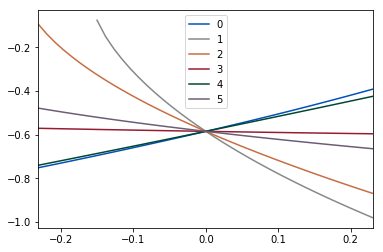

In [10]:
# Here we calculate the KL distance of a Rayleigh distribution with respect to a Normal. In 
# both cases, we use unit scale and zero location parameters. For each distribution, we
# first draw a length-100 sample of random variables, and calculate the empirical cumulative
# distribution function. We perform the following steps.
# Ⓐ Calulate metalog coefficient vectors 𝗮. Use the scipy.stats to generate 
#    arrays of cumulative distributions for each. We fit these CDFs to the
#    metalogs, to get coefficient vectors. Use two locally-defined functions, 
#    metalog_quantile_coeffs for unbounded distributions and metalog_quantile_coeffs_lb
#    for distributions whose regions of support are lower-bounded.
start_time = datetime.utcnow()
print('Most-recent start ' + start_time.strftime('%y%m%d_%H%M%SZ') + ' UTC.')
𝘔 = 6
𝒫_norm = np.transpose(a = np.array([(sci.stats.norm.cdf(x = 𝓆,
                                                              loc = 0,
                                                              scale = 1),
                                        𝓆)
                                  for 𝓆 in np.arange(start = sci.stats.norm.ppf(q = 0.025,
                                                                                     loc = 0,
                                                                                     scale = 1),
                                                             stop = sci.stats.norm.ppf(q = 0.975,
                                                                                         loc = 0,
                                                                                         scale = 1),
                                                             step = 0.05)]))
𝗮_norm = metalog_quantile_coeffs(𝘔 = 𝘔, 
                                 𝒫 = 𝒫_norm)
𝒫_rayl = np.transpose(a = np.array([(sci.stats.rayleigh.cdf(x = 𝓆,
                                                              loc = 0,
                                                              scale = 1),
                                        𝓆)
                                  for 𝓆 in np.arange(start = sci.stats.rayleigh.ppf(q = 0.025,
                                                                                     loc = 0,
                                                                                     scale = 1),
                                                             stop = sci.stats.rayleigh.ppf(q = 0.975,
                                                                                         loc = 0,
                                                                                         scale = 1),
                                                             step = 0.05)]))
𝗮_rayl = metalog_quantile_coeffs_lb(𝘔 = 𝘔, 
                                   𝒫 = 𝒫_rayl, 
                                   𝒷ℓ = 0)
#
# Ⓑ Construct vectors of derivatives of the metalog-fit PPFs of which the integrand
#    in (5) is comprised. We get this using internally-defined functions "m_𝗮" for unbounded
#    distributions like our Gaussian, and "m_𝗮_lb" for lower-bounded distributions such as our 
#    Rayeleigh.
𝜂_norm = np.arange(start = 0.0001,
                    stop = 1,
                    step = 0.0001)
𝜂_rayl = np.arange(start = 0.0001,
                    stop = 1,
                    step = 0.0001)
m_norm = m_𝗮(𝛂 = 𝗮_norm, 
             𝜂 = 𝜂_norm)
m_rayl = m_𝗮_lb(𝛂 = 𝗮_rayl, 
                𝒷ℓ = 0,
                𝜂 = 𝜂_rayl)
M_norm = M_𝗮(𝛂 = 𝗮_norm, 
             𝜂 = 𝜂_norm)
M_rayl = M_𝗮_lb(𝛂 = 𝗮_rayl, 
                𝒷ℓ = 0,
                𝜂 = 𝜂_rayl)

𝛂 = 𝗮_rayl
𝜂 = np.arange(start = 1/2,
            stop = 1,
            step = 0.00001)
#
# Ⓓ Find the vector-space of our baseline vector 𝗮0. This, in conjunction with
#   𝗮0 itself gives us the vicinity we are going to scan in order to understand
#   the variation of 𝜙(𝗮). We perform a "constructive" QR factorization of 
#   𝗮0. This produces an orthonormal set.  The first vector is congruent with
#   𝗮0 and the remainder are orthonormal projections onto the nullspace. Capture
#   this orthonormal set as a dictionary.
𝗮0 = np.expand_dims(a = 𝗮_rayl,
                    axis = -1)
𝗔 = {idx : np.expand_dims(a = vec,
                      axis = -1) 
         for (idx, vec) in enumerate(np.transpose(np.linalg.qr(a = 𝗮0,
                                                               mode = 'complete')[0]))}
#
# Ⓔ Generate a set of offset factors. We scan the vector-space neighborhood
#    of 𝗮0 by calculating 𝜙(𝗮0 + 𝜊ᵤ ||𝗮0|| 𝗮ᵥ) where 𝜊ᵤ ∈ {-𝜀, ..., 𝜀} for 𝜀 ≪ 1.
𝜀 = 0.25
𝝾 = dict(enumerate(np.arange(start = -𝜀,
                              stop = 𝜀 + 0.005,
                              step = 𝜀/20)*np.linalg.norm(𝗮0)))
#
# Ⓕ Scan the vector space. Collect the results in a dataframe.
𝚿 = pd.DataFrame(data = [[𝜙_𝗮(𝛂 = 𝗔.get(μ)*𝝾.get(ν)*np.linalg.norm(𝗮0)+𝗮0, 
                              𝜂 = 𝜂) for ν in 𝝾.keys()]
                            for μ in 𝗔.keys()],
                 index = 𝗔.keys(),
                 columns = 𝝾.values())
finish_time = datetime.utcnow()
print('Most-recent complete ' + finish_time.strftime('%y%m%d_%H%M%SZ') + ' UTC.')
print('Execution time: ' + str((finish_time - start_time).seconds) + ' seconds')
col_palette = dict(enumerate(['#0051ba', '#85898a', '#c66e43', '#971b2f', '#004733', '#6c5c76']))
𝚿.T.plot(color = list(col_palette.values()))

Most-recent start 191205_190614Z UTC.
Most-recent complete 191205_190904Z UTC.
Execution time: 170 seconds


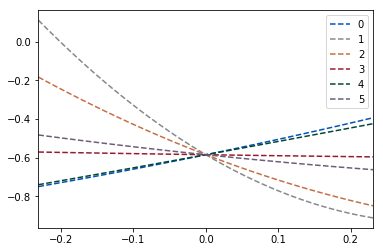

In [11]:
start_time = datetime.utcnow()
print('Most-recent start ' + start_time.strftime('%y%m%d_%H%M%SZ') + ' UTC.')
𝗮0 = np.expand_dims(a = 𝗮_rayl,
                    axis = -1)
𝗔 = {idx : np.expand_dims(a = vec,
                      axis = -1) 
         for (idx, vec) in enumerate(np.transpose(np.linalg.qr(a = 𝗮0,
                                                               mode = 'complete')[0]))}
𝝾 = dict(enumerate(np.arange(start = -𝜀,
                              stop = 𝜀 + 0.005,
                              step = 𝜀/20)*np.linalg.norm(𝗮0)))
𝒷ℓ = 0
𝜂 = np.arange(start = 1/2,
            stop = 1,
            step = 0.00001)

# Construct a Hessian matrix for a lower semi-bounded distribution. Our arguments
𝜉 = 𝒷ℓ + exp(metalog_quantile_series(len(𝗮0)))
Φ = Matrix([diff(log(1/diff(𝜉, 𝘺)), a[𝜈])
        for 𝜈 in range(len(𝗮0))]).subs({a[key] : val
                                        for (key, val) in dict(enumerate(𝗮0)).items()})
𝝣 = Matrix([[diff(log(1/diff(𝜉, 𝘺)), a[𝜈], a[μ])
                for 𝜈 in range(len(𝗮0))]
            for μ in range(len(𝗮0))]).subs({a[key] : val
                                            for (key, val) in dict(enumerate(𝗮0)).items()})
𝚫 = np.expand_dims(a = np.trapz(y = np.hstack(list(map(lambdify(𝘺, Φ),𝜂))),
                                 x = 𝜂),
                   axis = 1)
𝝜 = np.trapz(y = np.array(list(map(lambdify(𝘺, 𝝣),𝜂))),
             x = 𝜂,
             axis = 0)
𝜑0 = 𝜙_𝗮(𝛂 = 𝗮0,
         𝜂 = 𝜂)
𝚯 = pd.DataFrame(data = [[𝜑0 + np.asscalar(𝝾.get(𝜇)*np.dot(a = np.transpose(𝚫),
                                                            b = 𝗔.get(𝜈))*np.linalg.norm(𝗮0) +\
                                            (𝝾.get(𝜇)**2)*(np.linalg.norm(𝗮0)**2)*\
                                                         np.dot(b = np.dot(a = 𝝜,
                                                                            b = 𝗔.get(𝜈)),
                                                                 a = np.transpose(𝗔.get(𝜈)))/2)
                                for 𝜇 in 𝝾.keys()]
                            for 𝜈 in 𝗔.keys()],
                 index =  𝗔.keys(),
                 columns = 𝝾.values())
finish_time = datetime.utcnow()
print('Most-recent complete ' + finish_time.strftime('%y%m%d_%H%M%SZ') + ' UTC.')
print('Execution time: ' + str((finish_time - start_time).seconds) + ' seconds')
col_palette = dict(enumerate(['#0051ba', '#85898a', '#c66e43', '#971b2f', '#004733', '#6c5c76']))
𝚯.T.plot(ls = '--',
         color = list(col_palette.values()))

In [18]:
np.linalg.qr(𝝜)

(array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [-0.        , -0.87622806,  0.38770795,  0.25505636, -0.05340636,
          0.11832563],
        [-0.        , -0.42203005, -0.66921004, -0.37138299, -0.37964583,
         -0.30330228],
        [-0.        , -0.10550516,  0.39899229, -0.6782239 ,  0.4248926 ,
         -0.43491658],
        [-0.        , -0.05124226, -0.00872674, -0.55635982, -0.04497438,
          0.82809368],
        [-0.        , -0.2008928 , -0.49251342,  0.16582228,  0.81881645,
          0.13825776]]),
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -1.05315844e+01, -5.18602966e+00,
         -1.22219522e+00, -6.20524937e-01, -2.49194558e+00],
        [ 0.00000000e+00,  0.00000000e+00, -2.56635399e-01,
          1.19319472e-01, -1.00145719e-03, -1.82580546e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.0000000

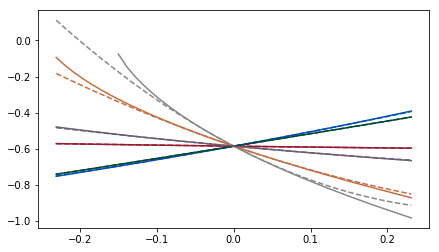

In [13]:
col_palette = dict(enumerate(['#0051ba', '#85898a', '#c66e43', '#971b2f', '#004733', '#6c5c76']))
plt.figure(figsize=(7, 4))
for ψ in 𝚿.index:
    plt.plot(𝚿.columns,
             𝚿.loc[ψ],
             c = col_palette.get(ψ))
for ϑ in 𝚯.index:
    plt.plot(𝚯.columns,
             𝚯.loc[ϑ],
             ls = '--',
             c = col_palette.get(ϑ))

In [14]:
np.linalg.eigvals(a = 𝝜)

array([1.20795796e+01, 3.08631399e-01, 2.53052678e-02, 2.22118089e-03,
       1.53391620e-05, 0.00000000e+00])

In [15]:
𝛥_k = 0.15*np.linalg.norm(x = 𝗮0)
𝗽ks = - 𝛥_k
𝜏 = (np.linalg.norm(x = 𝚫,
                    ord = 2)**3)/(𝛥_k*np.asscalar(np.dot(a = np.transpose(a = 𝚫),
                                                         b = np.dot(a = 𝝜,
                                                                    b = 𝚫))))
(𝜏, 𝛥_k)

(1.9126603250866656, 0.13863371337045133)

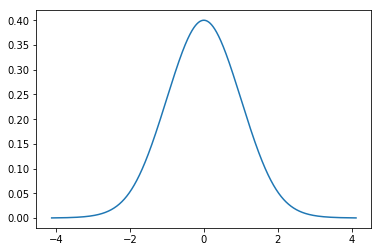

In [16]:
plt.plot(M_norm, 
         m_norm )

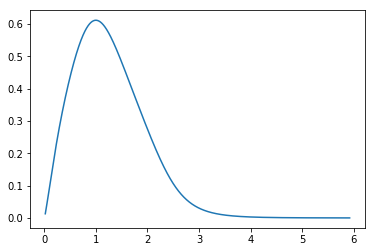

In [17]:
plt.plot(M_rayl, 
         m_rayl )